<a href="https://colab.research.google.com/github/nizzyblu/MachineLearning/blob/main/Anomaly_Detection_with_Supervised_ML_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Algorithm for detecting the type of the attacks that affect IoT devices.

Dataset was obtained in: https://datahub.io/machine-learning/kddcup99#data

Students Names: Genesis Resto & Arnaldo Fajardo

Mentor: Dr. Pei-Chi Huang


Libraries

In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import KFold
import time
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import itertools
from sklearn import preprocessing
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt

These lines of code install the `datapackage` library, load a data package from a specific URL, and then read and print tabular data from the loaded package using pandas.

In [2]:
!pip install datapackage
import datapackage

data_url = 'https://datahub.io/machine-learning/kddcup99/datapackage.json'

# to load Data Package into storage
package = datapackage.Package(data_url)

# to load only tabular data
resources = package.resources
for resource in resources:
    if resource.tabular:
        df = pd.read_csv(resource.descriptor['path'])
        print (df)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.9/68.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.5 MB/s eta 0:00:00
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10745 sha256=6f34161df6dd09725cd8ce2bb8a428d23bb1a7a4aaee01f08cd197f54c1aeb54
  Stored in directory: /root/.cache/pip/wheels/9c/ea/66/8e45247b09052a933eb1a680b7c64802298faba58aac9b346b
  Created

Finding missing values of all features. If no missing value found, so we can further proceed to our next step.

In [3]:
#Returns a specified value if the expression is NULL.
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
lnum_compromised               0
lroot_shell                    0
lsu_attempted                  0
lnum_root                      0
lnum_file_creations            0
lnum_shells                    0
lnum_access_files              0
lnum_outbound_cmds             0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

First we check some string features. When some of the features are string, we should change that to a numeric value. Using LabelEncoder() with the order `[0, 1, 2...class-1]` works fine

In [4]:
#Change some features ['protocol_type'] of X (continious target) to numeric value
le_protocol = preprocessing.LabelEncoder()
df['protocol_type'] = le_protocol.fit_transform(df['protocol_type'])

In [5]:
#Change some features ['service'] of X (continious target) to numeric value
le_service = preprocessing.LabelEncoder()
df['service'] = le_service.fit_transform(df['service'])

In [6]:
#Change some features ['flag'] of X (continious target) to numeric value
le_flag = preprocessing.LabelEncoder()
df['flag'] = le_flag.fit_transform(df['flag'])

In [7]:
#Change some features ['label'] of y (continious target) to numeric value
le_label=preprocessing.LabelEncoder()
df['label'] = le_label.fit_transform(df['label'])

In [8]:
classes = le_label.classes_
for i, attack in enumerate(classes):
    print(f"Attack: {attack}, Number: {i}")

Attack: back, Number: 0
Attack: buffer_overflow, Number: 1
Attack: ftp_write, Number: 2
Attack: guess_passwd, Number: 3
Attack: imap, Number: 4
Attack: ipsweep, Number: 5
Attack: land, Number: 6
Attack: loadmodule, Number: 7
Attack: multihop, Number: 8
Attack: neptune, Number: 9
Attack: nmap, Number: 10
Attack: normal, Number: 11
Attack: perl, Number: 12
Attack: phf, Number: 13
Attack: pod, Number: 14
Attack: portsweep, Number: 15
Attack: rootkit, Number: 16
Attack: satan, Number: 17
Attack: smurf, Number: 18
Attack: spy, Number: 19
Attack: teardrop, Number: 20
Attack: warezclient, Number: 21
Attack: warezmaster, Number: 22


Heatmap: As we can see in the heatmap, there are several features that are correlated which negatively affects the performance of ML models.

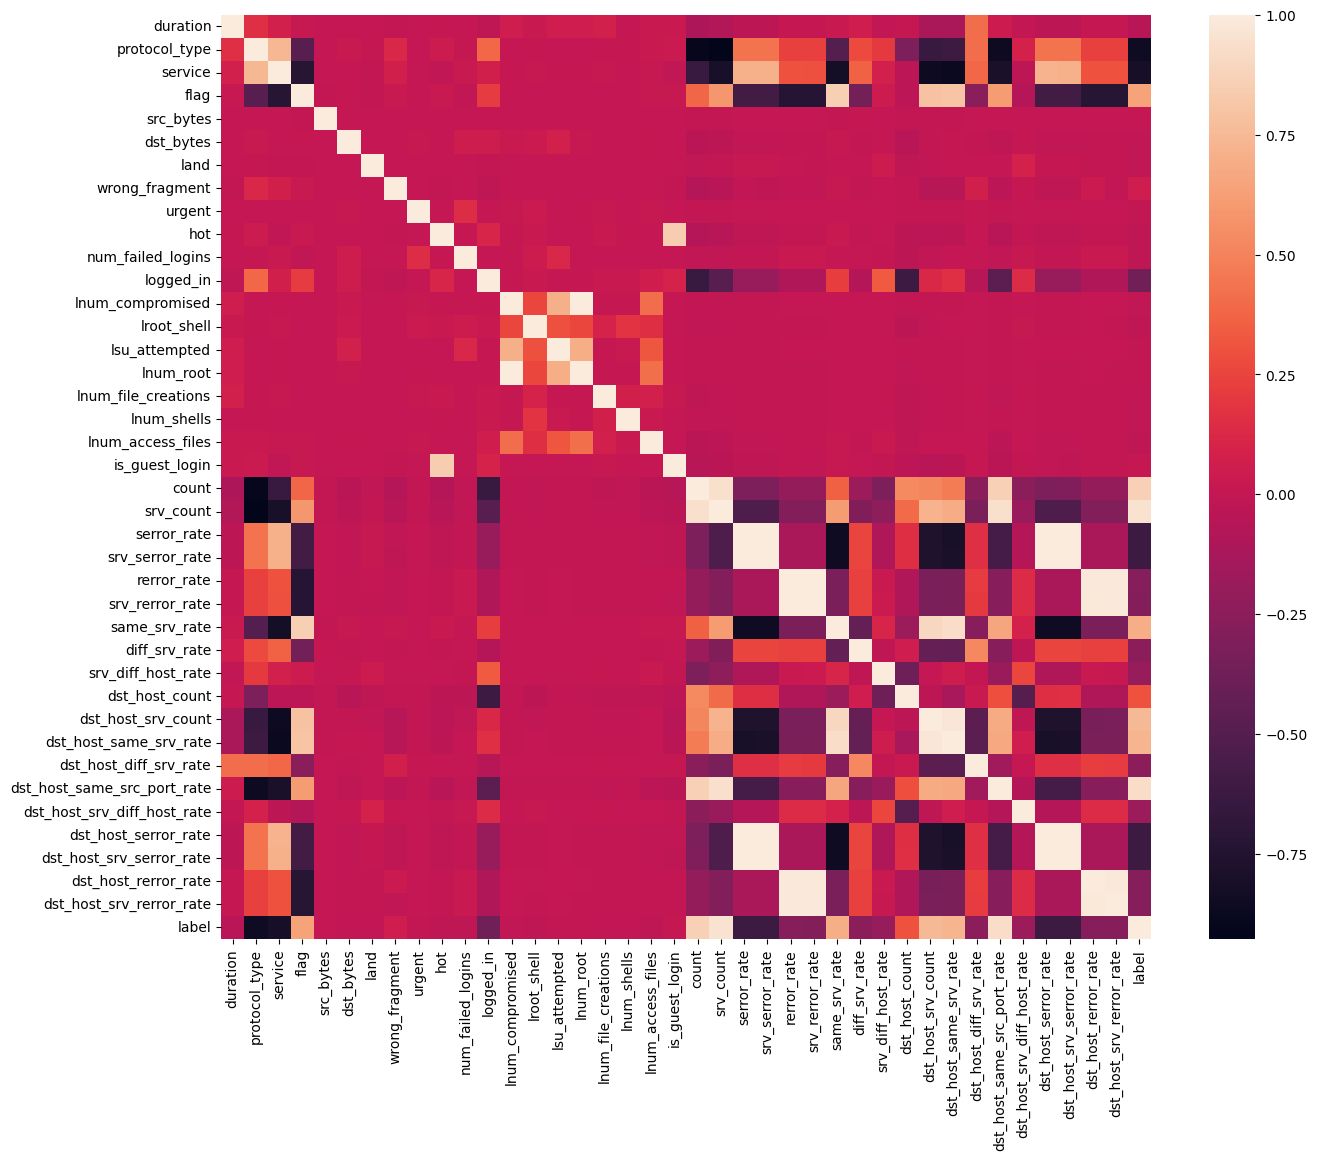

In [9]:
#keep columns where there are more than 1 unique values
df = df[[col for col in df if df[col].nunique() > 1]]# This feaures are not in the index (df) anymore:
                                                     #'lnum_outbound_cmds', 'is_host_login' because they are 0
corr = df.corr()
plt.figure(figsize =(15, 12))
sns.heatmap(corr)
plt.show()

This code snippet identifies pairs of features in a dataset that have a correlation value greater than 0.95 and stores them in the `high_correlation_features` list, then it prints the names of those features along with their correlation value.

In [10]:
high_correlation_features = []

#Iterate on each pair of characteristics and their correlation values
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.95:  #Check if the correlation value is greater than 0.80
            feature_i = corr.columns[i]
            feature_j = corr.columns[j]
            correlation_value = corr.iloc[i, j]
            high_correlation_features.append((feature_i, feature_j, correlation_value))

#Print the characteristics with a correlation greater than 0.80 together with their correlation value.
for features in high_correlation_features:
    print(f"'{features[0]}' and '{features[1]}'. Correlation Value: {features[2]}.")



'lnum_compromised' and 'lnum_root'. Correlation Value: 0.9938277978733956.
'srv_count' and 'label'. Correlation Value: 0.9505103628512889.
'serror_rate' and 'srv_serror_rate'. Correlation Value: 0.9983615065593786.
'serror_rate' and 'dst_host_serror_rate'. Correlation Value: 0.9986729674316287.
'serror_rate' and 'dst_host_srv_serror_rate'. Correlation Value: 0.9978492476329098.
'srv_serror_rate' and 'dst_host_serror_rate'. Correlation Value: 0.9978352994314563.
'srv_serror_rate' and 'dst_host_srv_serror_rate'. Correlation Value: 0.999304108882672.
'rerror_rate' and 'srv_rerror_rate'. Correlation Value: 0.9947309533247035.
'rerror_rate' and 'dst_host_rerror_rate'. Correlation Value: 0.9869947908669967.
'rerror_rate' and 'dst_host_srv_rerror_rate'. Correlation Value: 0.9851995522241864.
'srv_rerror_rate' and 'dst_host_rerror_rate'. Correlation Value: 0.9821663404802431.
'srv_rerror_rate' and 'dst_host_srv_rerror_rate'. Correlation Value: 0.9865705421991756.
'dst_host_srv_count' and 'dst_

Drop everything that is highly correlated with a value more than `.95`

In [11]:
# This variable is highly correlated with num_compromised and should be ignored for analysis.
df.drop('lnum_root', axis = 1, inplace = True)

# This variable is highly correlated with serror_rate and should be ignored for analysis.
df.drop('srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
df.drop('srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_serror_rate and should be ignored for analysis.
df.drop('dst_host_srv_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
df.drop('dst_host_serror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
df.drop('dst_host_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with rerror_rate and should be ignored for analysis.
df.drop('dst_host_srv_rerror_rate', axis = 1, inplace = True)

# This variable is highly correlated with srv_rerror_rate and should be ignored for analysis.
df.drop('dst_host_same_srv_rate', axis = 1, inplace = True)


Checking the heatmap again without correlation more than .95

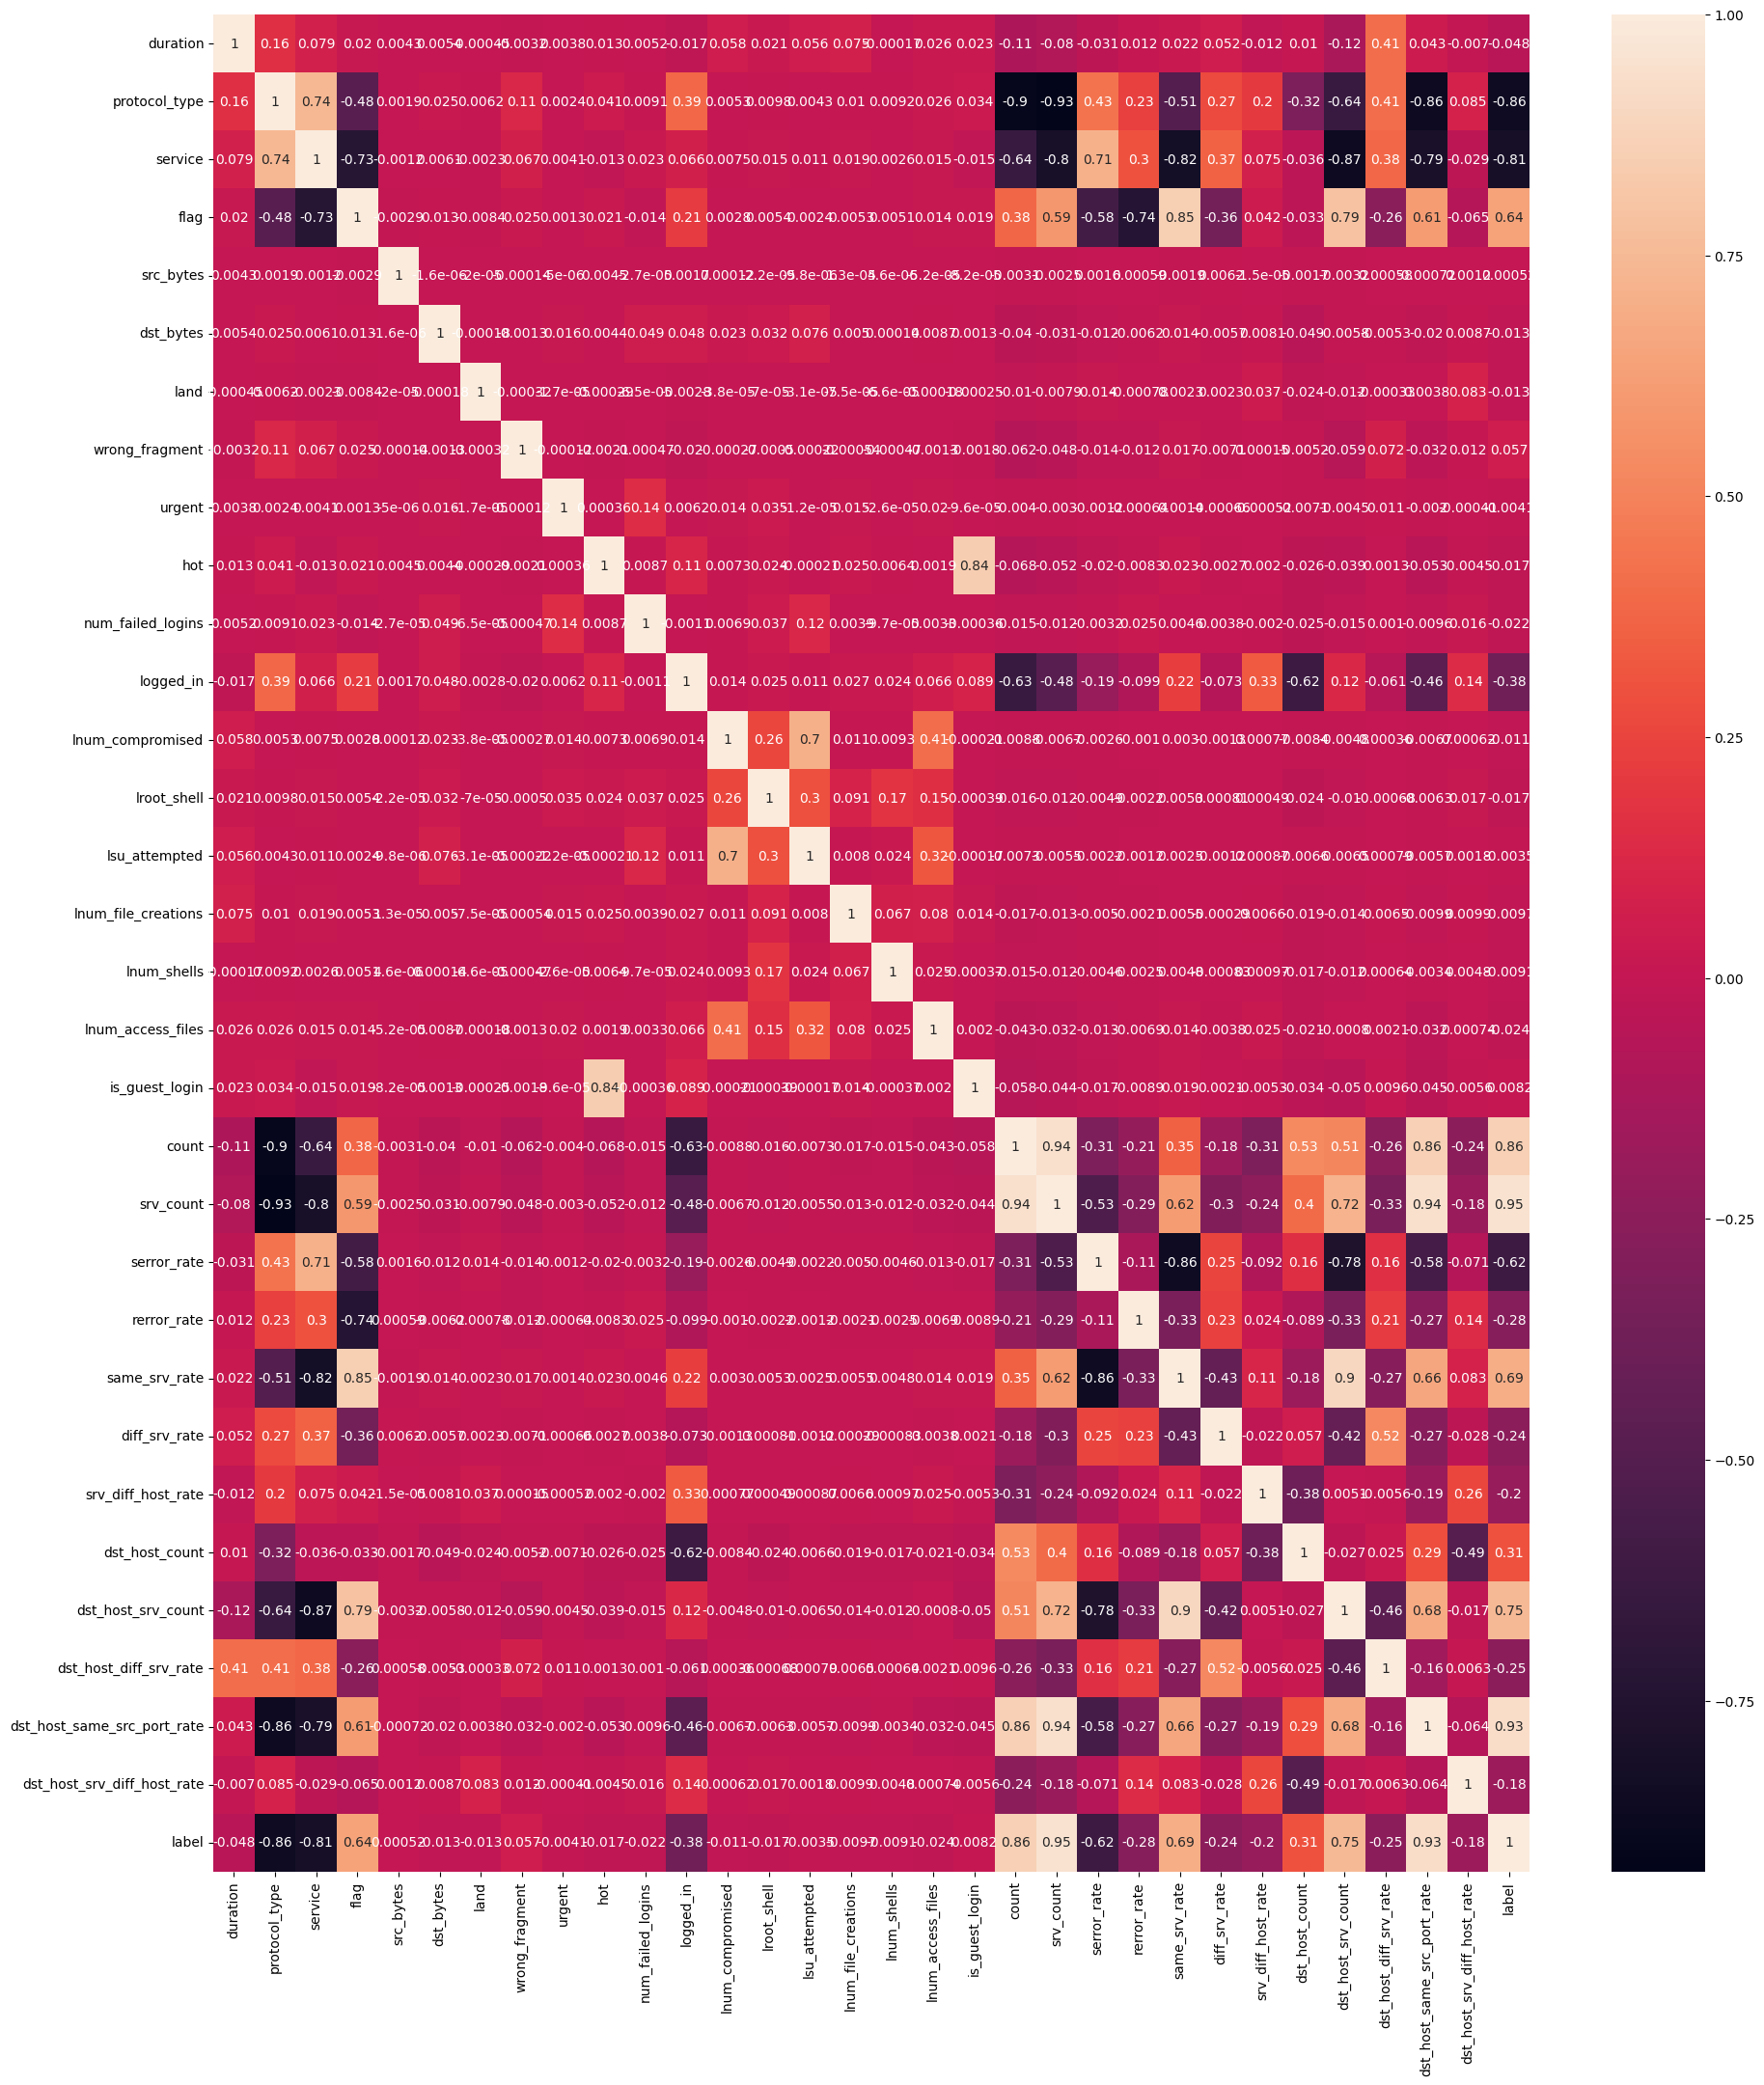

In [12]:
#df = df[[col for col in df if df[col].nunique() > 1]]
corr = df.corr()
plt.figure(figsize =(22, 25))
sns.heatmap(corr,annot=True)
plt.show()

This code returns a list of column names from a DataFrame (`df`) just to review all the labels

In [13]:
df.columns.tolist()

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'lnum_compromised',
 'lroot_shell',
 'lsu_attempted',
 'lnum_file_creations',
 'lnum_shells',
 'lnum_access_files',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'label']

Set X as the Continious data and Y as the Predictor. Then split the data.

In [14]:
X = df[['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
        'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_file_creations', 'lnum_shells', 'lnum_access_files', 'is_guest_login', 'count', 'srv_count',
        'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_diff_srv_rate',
        'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate']].values #Continuos Target

y = df['label'].values #Predictor


X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.2, random_state=40)#spliting the data



Let see the shape of our training data in x and y:

In [15]:
print('Shape of x_trainset: {}'.format(X_trainset.shape))
print('Shape of y_trainset: {}'.format(y_trainset.shape))
print("\n")
print('Shape of x_testset: {}'.format(X_testset.shape))
print('Shape of y_testset: {}'.format(y_testset.shape))

Shape of x_trainset: (395216, 31)
Shape of y_trainset: (395216,)


Shape of x_testset: (98804, 31)
Shape of y_testset: (98804,)


Modeling the Decision Tree algorithm and Prediction:

In [16]:
#Decision Tree Classifier for Modeling
clf_DT=DecisionTreeClassifier(criterion="entropy", max_depth = 4)
start_timeDT = time.time() #Start counting the training time
clf_DT.fit(X_trainset,y_trainset)
training_timeDT = time.time()#Finish counting the training time
timeDT=training_timeDT-start_timeDT
print("Training time: {} seconds".format(timeDT))


Training time: 0.8167307376861572 seconds


In [17]:
#Prediction for Decision Tree
start_timeDT= time.time()
predDT = clf_DT.predict(X_testset)
pred_timeDT = time.time()
timePred_DT=pred_timeDT-start_timeDT
print("Time prediction for Decision Tree: {} seconds".format(timePred_DT))

Time prediction for Decision Tree: 0.016933917999267578 seconds


Modeling the Gaussian Naive Bayes algorithm and Prediction:

In [18]:
#Gaussian Naive Bayes Classifier for Modeling
clf_GNB=GaussianNB()
start_timeGNB = time.time() #Start counting the training time
clf_GNB.fit(X_trainset,y_trainset)
training_timeGNB = time.time()#Finish counting the training time
timeGNB=training_timeGNB-start_timeGNB
print("Training time: {} seconds".format(timeGNB))

Training time: 0.2856566905975342 seconds


In [19]:
#Prediction for Gaussian Naive Bayes
start_timeGNB= time.time()
predGNB=clf_GNB.predict(X_testset)
pred_timeGNB = time.time()
timePred_GNB=pred_timeGNB-start_timeGNB
print("Time prediction for Gaussian Naive Bayes: {} seconds".format(timePred_GNB))

Time prediction for Gaussian Naive Bayes: 0.461698055267334 seconds


Modeling the Random Forest algorithm and Prediction:

In [20]:
#Random Forest Classifier for Modeling
clf_RF=RandomForestClassifier(n_estimators=100)
start_time = time.time() #Start counting the training time
clf_RF.fit(X_trainset,y_trainset)
training_time = time.time()#Finish counting the training time
timeRF=training_time-start_time
print("Training time: {} seconds".format(timeRF))



Training time: 30.19140887260437 seconds


In [21]:
#Prediction for Random Forest
start_timeRF= time.time()
predRF=clf_RF.predict(X_testset)
pred_timeRF = time.time()
timePred_RF=pred_timeRF-start_timeRF
print("Time prediction for Random Forest: {} seconds".format(timePred_RF))

Time prediction for Random Forest: 1.6160557270050049 seconds


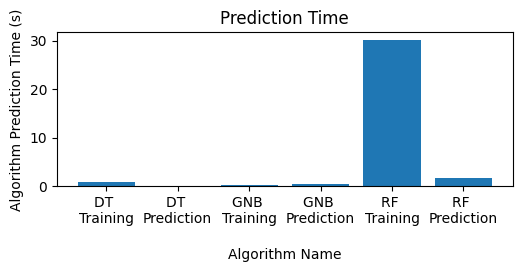

In [22]:
algorithmsNames=['DT \nTraining', 'DT \nPrediction','GNB \nTraining','GNB \nPrediction','RF \nTraining','RF \nPrediction']
algorithmsTimes=[timeDT,timePred_DT,timeGNB,timePred_GNB,timeRF,timePred_RF]
plt.figure(figsize=(20,2))
plt.subplot(131)
plt.bar(algorithmsNames, algorithmsTimes)
plt.ylabel("Algorithm Prediction Time (s)")
plt.xlabel("\nAlgorithm Name")
plt.title("Prediction Time")
plt.show()

Compute the Confusion Matrix for all algorithms

In [23]:
'''
      Function for Confusion Matrix: Obtained Coursera Labs Skills
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    #This lines adjust the matrix to the number presented in the matrix
    num_classes = len(classes)
    figsize = (max(min(num_classes * 0.5, 10), 6), max(min(num_classes * 0.5, 12), 4))

    plt.figure(figsize=figsize)

    #plt.figure(figsize=(5, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
def map_categories(y):
    attacks_mapping = {
        0: 'dos',
        1: 'u2r',
        2: 'r2l',
        3: 'r2l',
        4: 'r2l',
        5: 'probe',
        6: 'dos',
        7: 'u2r',
        8: 'r2l',
        9: 'dos',
        10: 'probe',
        11: 'normal',
        12: 'u2r',
        13: 'r2l',
        14: 'dos',
        15: 'probe',
        16: 'u2r',
        17: 'probe',
        18: 'dos',
        19: 'r2l',
        20: 'dos',
        21: 'r2l',
        22: 'r2l',
    }
    return [attacks_mapping[num] for num in y]

Confusion matrix, without normalization
[[77929     0     0   392]
 [    5     0     0     0]
 [   95     0     0     2]
 [    5     0     0   551]]
Confusion matrix, without normalization
[[78417     0     0    25]
 [    0    12     0     0]
 [    9    97    53     9]
 [  284     0     1   516]]
Confusion matrix, without normalization
[[78480     0     0     0]
 [    0     9     1     0]
 [    0     1   225     0]
 [    1     0     0   797]]


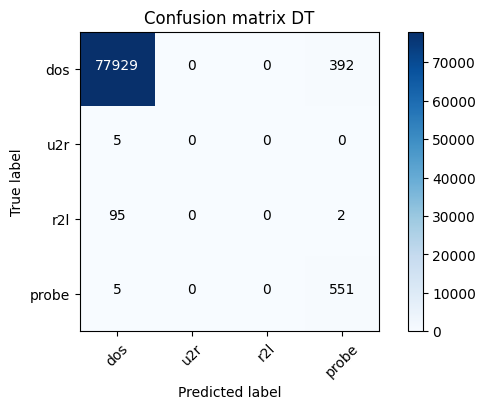

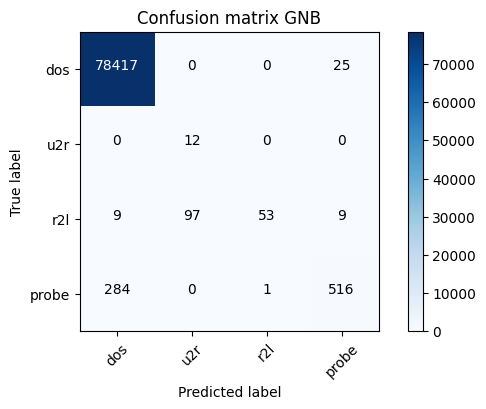

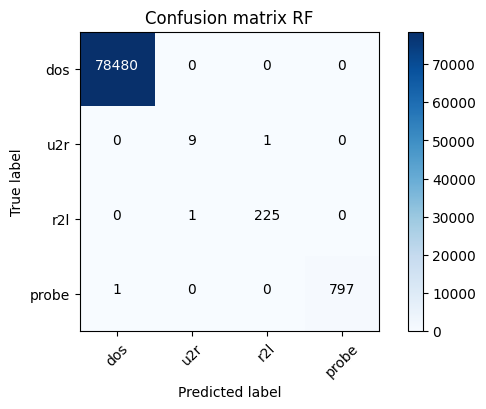

In [25]:
y_testset_mapped = map_categories(y_testset)

predDT_mapped = map_categories(predDT)
cmDT = confusion_matrix(y_testset_mapped, predDT_mapped, labels=['dos', 'u2r', 'r2l', 'probe'])
plot_confusion_matrix(cmDT, classes=['dos', 'u2r', 'r2l', 'probe'], normalize=False, title='Confusion matrix DT')

predGNB_mapped = map_categories(predGNB)
cmGNB = confusion_matrix(y_testset_mapped, predGNB_mapped, labels=['dos', 'u2r', 'r2l', 'probe'])
plot_confusion_matrix(cmGNB, classes=['dos', 'u2r', 'r2l', 'probe'], normalize=False, title='Confusion matrix GNB')

predRF_mapped = map_categories(predRF)
cmRF = confusion_matrix(y_testset_mapped, predRF_mapped, labels=['dos', 'u2r', 'r2l', 'probe'])
plot_confusion_matrix(cmRF, classes=['dos', 'u2r', 'r2l', 'probe'], normalize=False, title='Confusion matrix RF')

Plotting the times of the training and testing times (`s`)

Compute de Accuracy Score of Decision Tree:

In [26]:
#Compute de Accuracy Score of Decision Tree:
DTaccuracy=metrics.accuracy_score(y_testset, predDT)
print("DecisionTree Accuracy Score: ", DTaccuracy)

DecisionTree Accuracy Score:  0.9872879640500385


Compute the Accuracy Score of Gauss Naive Bayes:

In [27]:
#Compute the Accuracy Score of Gauss Naive Bayes
GNBaccuracy=metrics.accuracy_score(y_testset,predGNB)
print("Gauss Naive Bayes Accuracy Score: ", GNBaccuracy)

Gauss Naive Bayes Accuracy Score:  0.9477855147564876


Compute Accuracy Score of Random Forest

In [28]:
#Compute Accuracy Score of Random Forest
RFaccuracy=metrics.accuracy_score(y_testset, predRF)
print("Random Forest Acurracy Score: ", RFaccuracy)

Random Forest Acurracy Score:  0.9997672159021902


Plotting the Acurracy Score of the three algorithms

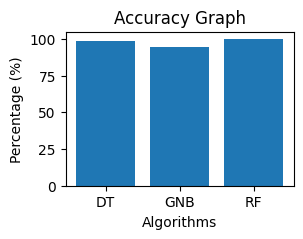

In [29]:
algorithms=['DT','GNB','RF']
score_Acc=[DTaccuracy*100,GNBaccuracy*100,RFaccuracy*100]
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.bar(algorithms, score_Acc)
plt.ylabel("Percentage (%)")
plt.xlabel("Algorithms")
plt.title("Accuracy Graph")
plt.show()

In [30]:
# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Cross-Validation:

In [31]:
# Perform cross-validation for Decision Tree
crossV_DT = cross_val_score(clf_DT, X_trainset, y_trainset, cv=5)
mean_DT=crossV_DT.mean()
std_DT=crossV_DT.std()
print("\nCross-Validation Scores (Decision Tree): ", crossV_DT)
print("Average Cross-Validation Score Accuracy (Decision Tree): {} \nStandard Deviation: {}".format(mean_DT,std_DT))



Cross-Validation Scores (Decision Tree):  [0.98758919 0.98757638 0.98757638 0.98761434 0.98803183]
Average Cross-Validation Score Accuracy (Decision Tree): 0.9876776246114373 
Standard Deviation: 0.00017764451335638395


In [32]:
# Perform cross-validation for Gaussian Naive Bayes
crossV_GNB = cross_val_score(clf_GNB, X_trainset, y_trainset, cv=5)
mean_GNB=crossV_GNB.mean()
std_GNB=crossV_GNB.std()
print("\nCross-Validation Scores (Gaussian Naive Bayes): ",crossV_GNB)
print("Average Cross-Validation Score Accuracy (Gaussian Naive Bayes): {}\nStandard Deviation: {}".format(mean_GNB,std_GNB))


Cross-Validation Scores (Gaussian Naive Bayes):  [0.93484641 0.9348962  0.93482029 0.93229002 0.96175499]
Average Cross-Validation Score Accuracy (Gaussian Naive Bayes): 0.9397215823123751
Standard Deviation: 0.011061407396246632


In [33]:
# Perform cross-validation for Random Forest
crossV_RF = cross_val_score(clf_RF, X_trainset, y_trainset, cv=5)
mean_RF=crossV_RF.mean()
std_RF=crossV_RF.std()
print("\nCross-Validation Scores (Random Forest): ", crossV_RF)
print("Average Cross-Validation Score Accuracy (Random Forest): {} \nStandard Deviation: {}" .format(mean_RF, std_RF))


Cross-Validation Scores (Random Forest):  [0.99972167 0.99969637 0.99979758 0.99977228 0.99965841]
Average Cross-Validation Score Accuracy (Random Forest): 0.999729261992399 
Standard Deviation: 5.03515979673176e-05


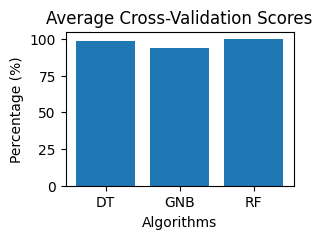

In [34]:
algorithm=['DT','GNB','RF']
avg_Acc=[mean_DT*100,mean_GNB*100,mean_RF*100]
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.bar(algorithm, avg_Acc)
plt.ylabel("Percentage (%)")
plt.xlabel("Algorithms")
plt.title("Average Cross-Validation Scores")
plt.show()

This line of code prints a classification report that includes various evaluation metrics (such as precision, recall, and F1-score) comparing the predicted labels (`predDT`) with the true labels (`y_testset`) for a classification task.

In [35]:
print (classification_report(y_testset, predDT))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82       474
           1       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00       240
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.99      0.99     21460
          10       0.00      0.00      0.00        42
          11       0.97      0.99      0.98     19273
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00        56
          15       0.29      0.89      0.44       215
          16       0.00      0.00      0.00         1
          17       0.94      0.93      0.94       306
          18       1.00    

This line of code prints a classification report that includes various evaluation metrics (such as precision, recall, and F1-score) comparing the predicted labels (`predGNB`) with the true labels (`y_testset`) for a classification task.

In [36]:
print (classification_report(y_testset, predGNB))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       474
           1       0.05      0.56      0.09         9
           2       0.00      0.00      0.00         0
           3       0.13      1.00      0.24        14
           4       0.00      0.00      0.00         4
           5       0.14      1.00      0.25       240
           6       0.00      0.00      0.00         3
           7       0.00      1.00      0.01         1
           8       0.00      0.00      0.00         1
           9       0.97      1.00      0.99     21460
          10       0.00      0.17      0.01        42
          11       0.99      0.77      0.87     19273
          12       0.00      0.00      0.00         2
          13       0.14      1.00      0.25         1
          14       0.31      1.00      0.47        56
          15       0.07      0.07      0.07       215
          16       0.00      0.00      0.00         1
          17       1.00    

This line of code prints a classification report that includes various evaluation metrics (such as precision, recall, and F1-score) comparing the predicted labels (`predRF`) with the true labels (`y_testset`) for a classification task.

In [37]:
print (classification_report(y_testset, predRF))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       474
           1       0.89      0.89      0.89         9
           3       1.00      1.00      1.00        14
           4       1.00      0.50      0.67         4
           5       1.00      1.00      1.00       240
           6       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00     21460
          10       1.00      0.95      0.98        42
          11       1.00      1.00      1.00     19273
          12       1.00      0.50      0.67         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00        56
          15       1.00      1.00      1.00       215
          16       0.00      0.00      0.00         1
          17       1.00      0.99      0.99       306
          18       1.00    


**Fold 1**
Precision (DT): 0.970773
Recall (DT): 0.980891
F1 score (DT): 0.975364


Precision (GNB): 0.977081
Recall (GNB): 0.906330
F1 score (GNB): 0.934819


Precision (RF): 0.999899
Recall (RF): 0.999899
F1 score (RF): 0.999896



**Fold 2**
Precision (DT): 0.972821
Recall (DT): 0.981499
F1 score (DT): 0.976605


Precision (GNB): 0.973563
Recall (GNB): 0.931319
F1 score (GNB): 0.946355


Precision (RF): 0.999879
Recall (RF): 0.999899
F1 score (RF): 0.999888



**Fold 3**
Precision (DT): 1.000000
Recall (DT): 1.000000
F1 score (DT): 1.000000


Precision (GNB): 1.000000
Recall (GNB): 1.000000
F1 score (GNB): 1.000000


Precision (RF): 1.000000
Recall (RF): 1.000000
F1 score (RF): 1.000000



**Fold 4**
Precision (DT): 0.983685
Recall (DT): 0.980912
F1 score (DT): 0.981476


Precision (GNB): 0.984235
Recall (GNB): 0.957998
F1 score (GNB): 0.964190


Precision (RF): 0.999990
Recall (RF): 0.999990
F1 score (RF): 0.999990



**Fold 5**
Precision (DT): 0.993388
Recall (DT): 0.994848
F1 sc

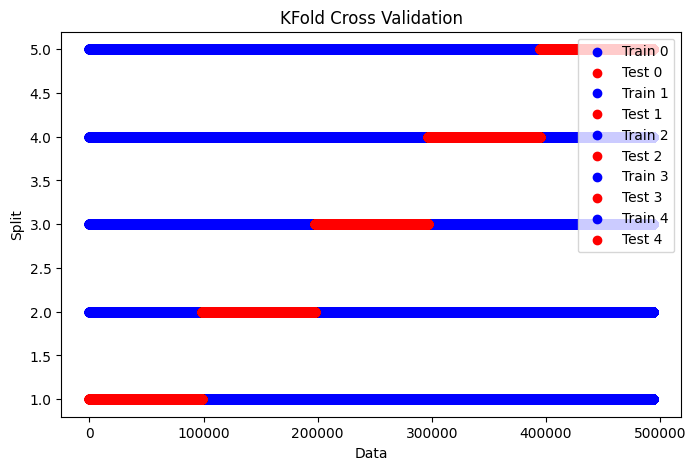

In [38]:
kf = KFold(n_splits=5)
plt.figure(figsize=(8, 5))
plt.title("KFold Cross Validation")
plt.xlabel("Data")
plt.ylabel("Split")

precision_scores_DT = []
precision_scores_GNB = []
precision_scores_RF = []
recall_scores_DT = []
recall_scores_GNB = []
recall_scores_RF = []
f1_scores_DT = []
f1_scores_GNB = []
f1_scores_RF = []

for i, (trainset, testset) in enumerate(kf.split(X)):
  X_train, X_test = X[trainset], X[testset]
  y_train, y_test = y[trainset], y[testset]

  predDT = clf_DT.predict(X_test)
  predGNB=clf_GNB.predict(X_test)
  predRF=clf_RF.predict(X_test)

  print(f"\n**Fold {i+1}**")
  '''
  Calculating precision, recall and f1-score for Decision Tree
  '''
  #precision tp / (tp + fp)
  precision_DT = precision_score(y_test, predDT, pos_label='pos', average='weighted')
  print('Precision (DT): %f' % precision_DT)
  precision_scores_DT.append(precision_DT)

  #recall: tp / (tp + fn)
  recall_DT = recall_score(y_test, predDT, pos_label='pos', average='weighted')
  print('Recall (DT): %f' % recall_DT)
  recall_scores_DT.append(recall_DT)

  #f1: 2 tp / (2 tp + fp + fn)
  f1_DT = f1_score(y_test, predDT, pos_label='pos', average='weighted')
  print('F1 score (DT): %f' % f1_DT)
  f1_scores_DT.append(f1_DT)
  print("\n")

  '''
  Calculating precision, recall and f1-score for Gaussian Naive Bayes
  '''
  #precision tp / (tp + fp)
  precision_GNB = precision_score(y_test, predGNB, pos_label='pos', average='weighted')
  print('Precision (GNB): %f' % precision_GNB)
  precision_scores_GNB.append(precision_GNB)

  #recall: tp / (tp + fn)
  recall_GNB = recall_score(y_test, predGNB, pos_label='pos', average='weighted')
  print('Recall (GNB): %f' % recall_GNB)
  recall_scores_GNB.append(recall_GNB)

  #f1: 2 tp / (2 tp + fp + fn)
  f1_GNB = f1_score(y_test, predGNB, pos_label='pos', average='weighted')
  print('F1 score (GNB): %f' % f1_GNB)
  f1_scores_GNB.append(f1_GNB)
  print("\n")

  '''
  Calculating precision, recall and f1-score for Random Forest
  '''
  #precision tp / (tp + fp)
  precision_RF = precision_score(y_test, predRF, pos_label='pos', average='weighted')
  print('Precision (RF): %f' % precision_RF)
  precision_scores_RF.append(precision_RF)

  #recall: tp / (tp + fn)
  recall_RF = recall_score(y_test, predRF, pos_label='pos', average='weighted')
  print('Recall (RF): %f' % recall_RF)
  recall_scores_RF.append(recall_RF)

  #f1: 2 tp / (2 tp + fp + fn)
  f1_RF = f1_score(y_test, predRF, pos_label='pos', average='weighted')
  print('F1 score (RF): %f' % f1_RF)
  f1_scores_RF.append(f1_RF)
  print("\n")

  plt.scatter(trainset, [i+1]*len(trainset), color='b', label=f"Train {i}")
  plt.scatter(testset, [i+1]*len(testset), color='r', label=f"Test {i}")

plt.legend()
plt.show()


In [39]:
'''
If we want to do average on scores...
'''
#Convert precision_scores_DT to a array
precision_DT = np.array(precision_scores_DT)
#Convert precision_scores_GNB to a array
precision_GNB = np.array(precision_scores_GNB)
#Convert precision_scores_RF to a array
precision_RF = np.array(precision_scores_RF)


#Convert recall_scores_DT to a array
recalls_DT = np.array(recall_scores_DT)
#Convert recall_scores_GNB to a array
recall_GNB = np.array(recall_scores_GNB)
#Convert recall_scores_RF to a array
recall_RF = np.array(recall_scores_RF)


#Convert f1_scores_DT to a array
f1_DT = np.array(f1_scores_DT)
#Convert f1_scores_GNB to a array
f1_GNB = np.array(f1_scores_GNB)
#Convert f1_scores_RF to a array
f1_RF = np.array(f1_scores_RF)


#Calculate the average of precision_DT
precision_avg_DT = np.mean(precision_DT)
#Calculate the average of precision_GNB
precision_avg_GNB = np.mean(precision_GNB)
#Calculate the average of precision_RF
precision_avg_RF = np.mean(precision_RF)


#Calculate the average of recall_DT
recall_avg_DT = np.mean(recall_DT)
#Calculate the average of recall_GNB
recall_avg_GNB = np.mean(recall_GNB)
#Calculate the average of recall_RF
recall_avg_RF = np.mean(recall_RF)


#Calculate the average of f1_DT
f1_avg_DT = np.mean(f1_DT)
#Calculate the average of f1_GNB
f1_avg_GNB = np.mean(f1_GNB)
#Calculate the average of f1_RF
f1_avg_RF = np.mean(f1_RF)

#Print Values:
print("\nAverage Scores for DT:")
print('Precision (Avg): %f' % precision_avg_DT)
print('Recall (Avg): %f' % recall_avg_DT)
print('F1 score (Avg): %f' % f1_avg_DT)

print("\nAverage Scores for GNB:")
print('Precision (Avg): %f' % precision_avg_GNB)
print('Recall (Avg): %f' % recall_avg_GNB)
print('F1 score (Avg): %f' % f1_avg_GNB)

print("\nAverage Scores for RF:")
print('Precision (Avg): %f' % precision_avg_RF)
print('Recall (Avg): %f' % recall_avg_RF)
print('F1 score (Avg): %f' % f1_avg_RF)


Average Scores for DT:
Precision (Avg): 0.984133
Recall (Avg): 0.994848
F1 score (Avg): 0.985470

Average Scores for GNB:
Precision (Avg): 0.985030
Recall (Avg): 0.946553
F1 score (Avg): 0.960658

Average Scores for RF:
Precision (Avg): 0.999945
Recall (Avg): 0.999949
F1 score (Avg): 0.999947


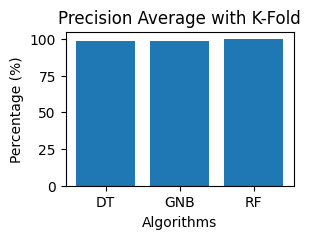

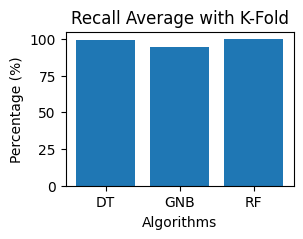

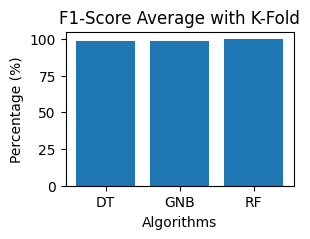

In [40]:
algorithms=['DT','GNB','RF']
avg_Pre=[precision_avg_DT*100,precision_avg_GNB*100,precision_avg_RF*100]
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.bar(algorithms, avg_Pre)
plt.ylabel("Percentage (%)")
plt.xlabel("Algorithms")
plt.title("Precision Average with K-Fold")
plt.show()

avg_Rec=[recall_avg_DT*100,recall_avg_GNB*100,recall_avg_RF*100]
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.bar(algorithms, avg_Rec)
plt.ylabel("Percentage (%)")
plt.xlabel("Algorithms")
plt.title("Recall Average with K-Fold")
plt.show()

avg_f1=[f1_avg_DT*100,f1_avg_GNB*100,f1_avg_RF*100]
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.bar(algorithms, avg_Pre)
plt.ylabel("Percentage (%)")
plt.xlabel("Algorithms")
plt.title("F1-Score Average with K-Fold")
plt.show()


This line of code transforms a set of class labels into numerical values using the transform method of a label encoder (le_label) and stores the resulting encoded labels in the class_labels variable.

In [41]:
class_labels = le_label.transform(le_label.classes_)

Confusion matrix, without normalization
[[    0     0     0     0     0     0     0     0     0   108     0    94
      0     0     0     1     0     0   271     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     2     0     0
      0     0     0     0     0     0     7     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     2     0     1
      0     0     0     0     0     0    11     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     1     0     0
      0     0     0     0     0     0     3     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0    42     0    55
      0     0     0     2     0     0   139     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0   

<Figure size 640x480 with 0 Axes>

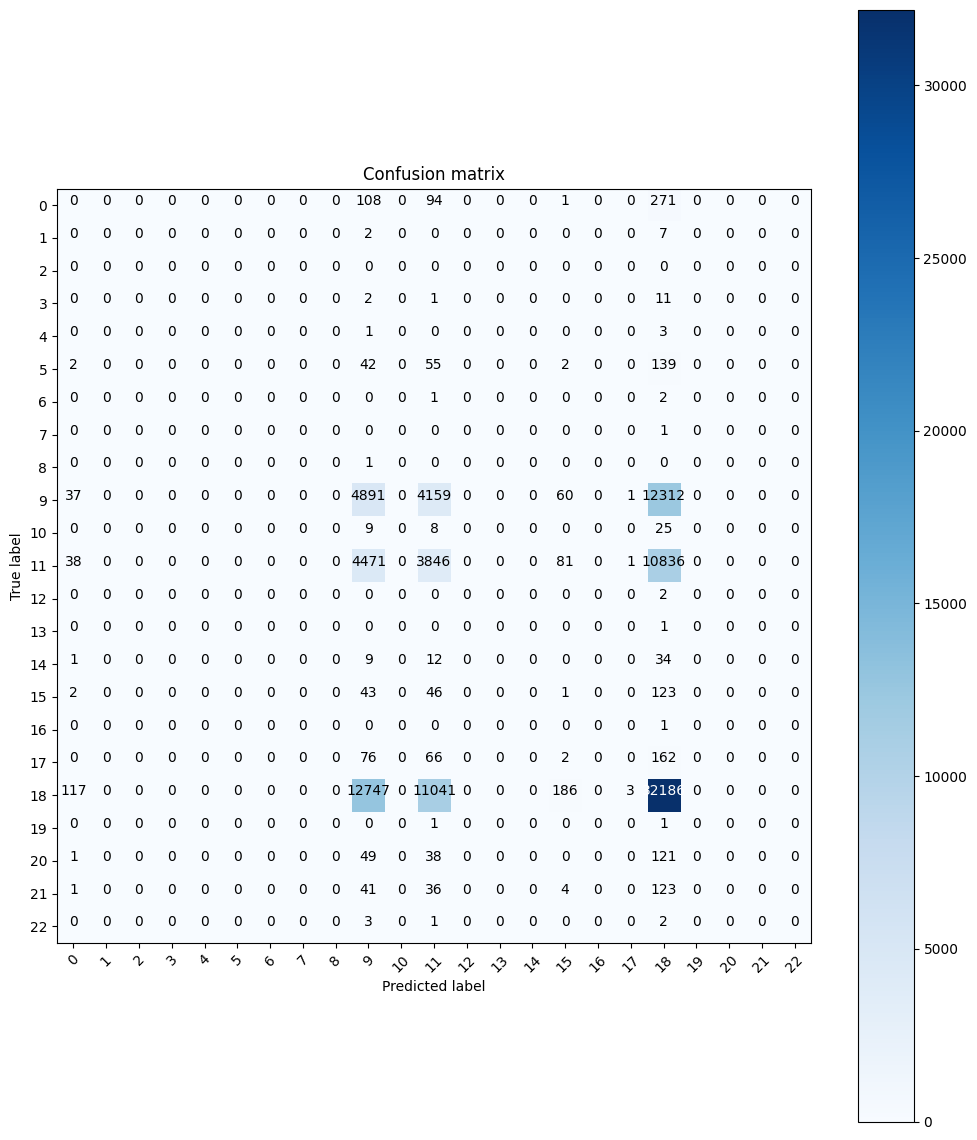

In [42]:
# Compute confusion matrix DT
cnf_matrixDT = confusion_matrix(y_testset, predDT, labels=class_labels)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixDT, classes=class_labels,normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[    0     0     1     0     0     8     0     1     0   110    10    66
      0     0     1     3     0     0   271     0     2     1     0]
 [    0     0     0     0     0     0     0     0     0     2     0     0
      0     0     0     0     0     0     7     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     2     0     1
      0     0     0     0     0     0    11     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     1     0     0
      0     0     0     0     0     0     3     0     0     0     0]
 [    1     1     0     1     0     3     0     0     0    44     6    38
      0     0     0     3     0     0   139     0     1     3     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0   

<Figure size 640x480 with 0 Axes>

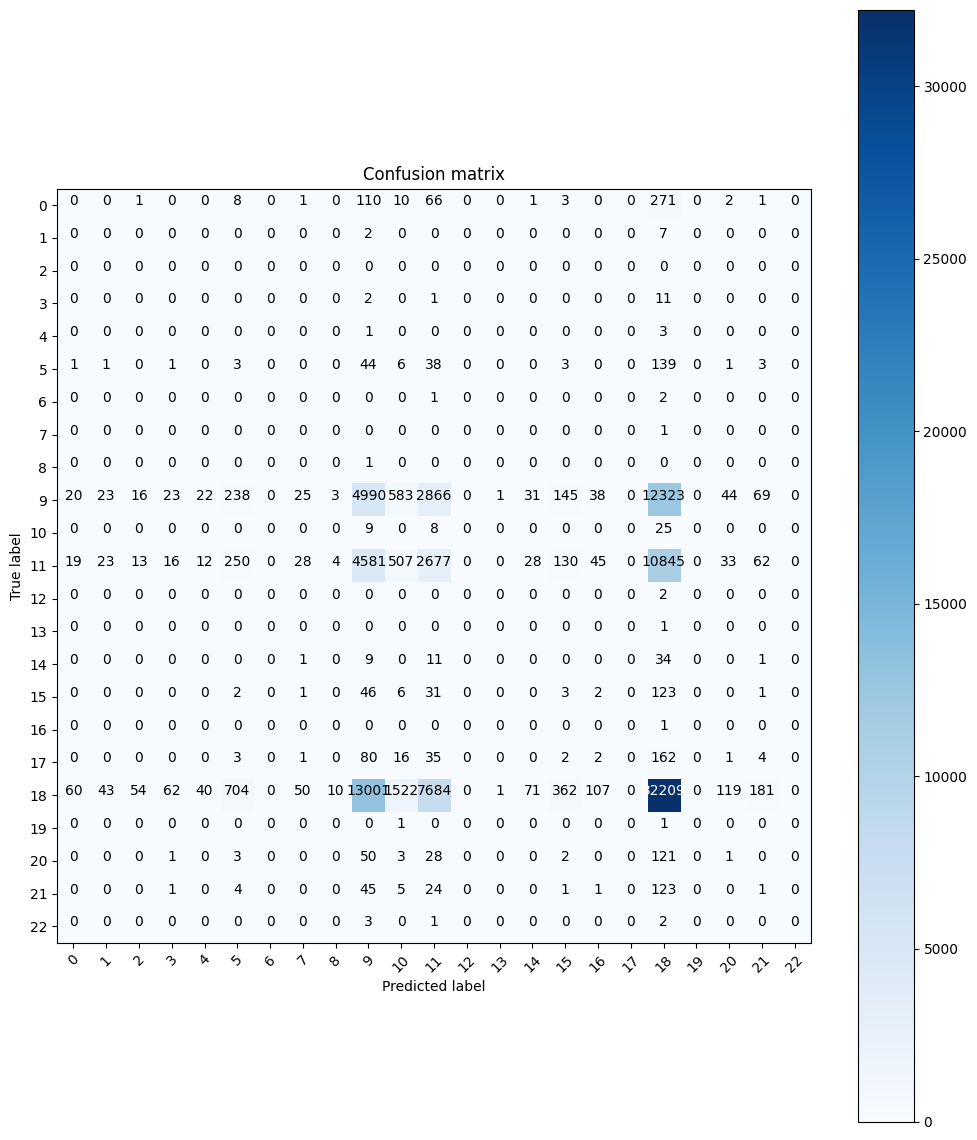

In [43]:
# Compute confusion matrix GBN
cnf_matrixGBN = confusion_matrix(y_testset, predGNB, labels=class_labels)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixGBN, classes=class_labels,normalize= False,  title='Confusion matrix')

Confusion matrix, without normalization
[[    0     0     0     0     0     0     0     0     0   108     0    94
      0     0     0     1     0     0   271     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     2     0     0
      0     0     0     0     0     0     7     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     2     0     1
      0     0     0     0     0     0    11     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     1     0     0
      0     0     0     0     0     0     3     0     0     0     0]
 [    2     0     0     0     0     0     0     0     0    42     0    55
      0     0     0     2     0     0   139     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     1
      0     0     0     0   

<Figure size 640x480 with 0 Axes>

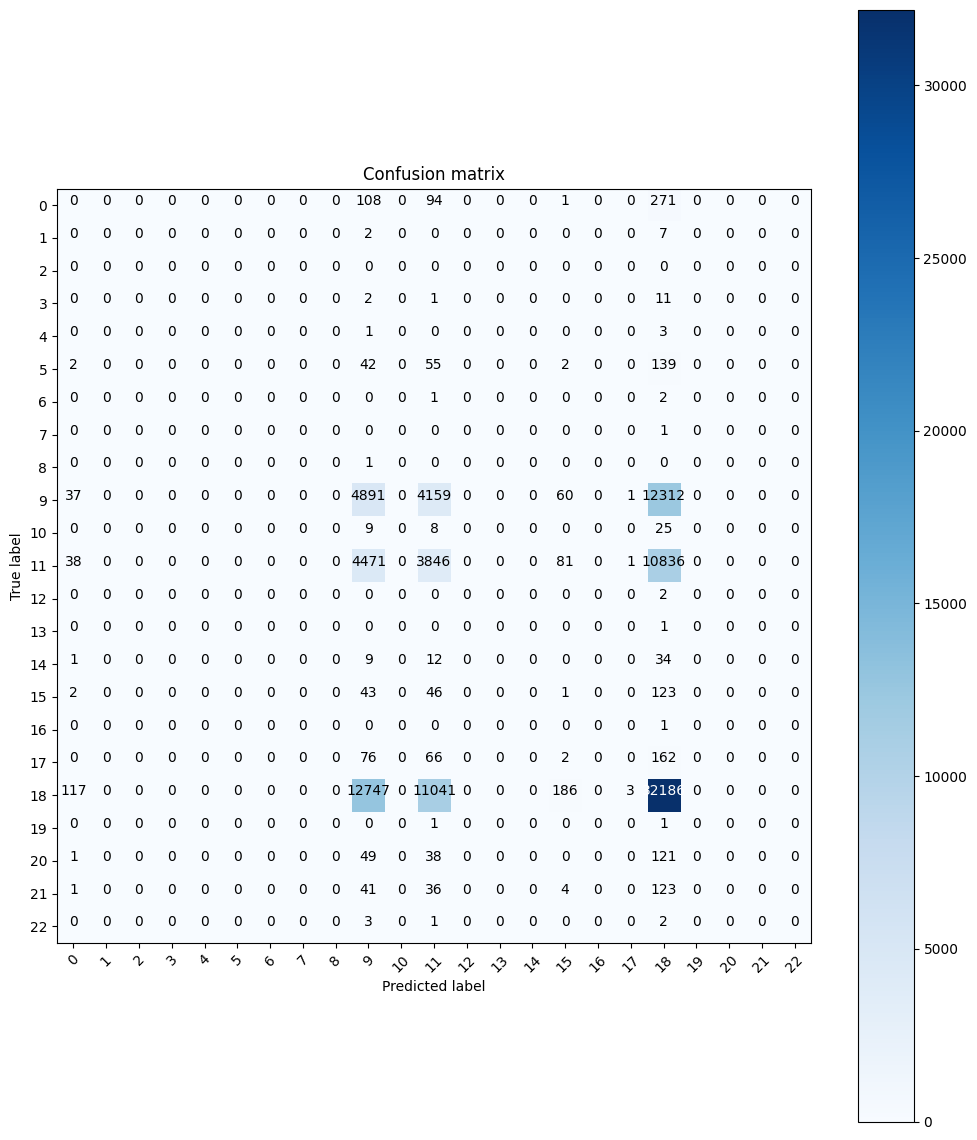

In [44]:
# Compute confusion matrix RF
cnf_matrixRF = confusion_matrix(y_testset, predRF, labels=class_labels)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrixDT, classes=class_labels,normalize= False,  title='Confusion matrix')

In [45]:
'''
text_representation = tree.export_text(clf_DT)
print(text_representation)
'''


'\ntext_representation = tree.export_text(clf_DT)\nprint(text_representation)\n'